# Covariate Shift, Importance Weighting, and Nyström-Accelerated KRR

This notebook accompanies experiments inspired by the paper **“Computational Efficiency under Covariate Shift in Kernel Ridge Regression” (NeurIPS 2025 - Spotlight Session)**.  
Its goal is to study **covariate shift**—the setting where train and test input distributions differ while the conditional distribution (and then also the target regression function) remains the same —and to evaluate **importance-weighted** Kernel Ridge Regression (KRR) alongside its **Nyström** efficient and scalable approximation.

**Why this matters.** Classical KRR can deliver optimal statistical guarantees in RKHSs, but its \(\mathcal{O}(n^3)\) time / \(\mathcal{O}(n^2)\) memory costs limit scalability. Under covariate shift, we must also correct for the distribution mismatch, typically via **importance weighting (IW)**. This notebook examines whether **random subspace methods (Nyström)** preserve accuracy *while* reducing compute under distribution shift.

**What you’ll find here.**
- A simulation setting with controlled **train/test distribution mismatch**.
- Three models:
  1. **KRR** (standard, unweighted),
  2. **IW-KRR** (importance-weighted),
  3. **IW–Nyström KRR** (importance-weighted + Nyström subspace).
- A **clean results summary** comparing mean test MSE across multiple runs.

> **Takeaway.** Following the paper, the Nyström-accelerated, importance-weighted estimator targets **the same statistical accuracy** as the full IW-KRR—*with far better computational profile*—provided the subspace size is chosen appropriately.



In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from dataclasses import dataclass, field
from typing import Callable, Dict, Tuple, Optional
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from bless import *         #import bless.py from the same folder

## 2. Configuration

In [10]:
# --- Settings ---
@dataclass
class Config:

    # distribution parameters
    mu_tr : np.ndarray= field(default_factory=lambda: np.array([0.7,0.7]))
    var_tr: np.ndarray= field(default_factory=lambda: np.diag(np.array([0.7,0.7])))
    mu_te: np.ndarray= field(default_factory=lambda: np.array([1.8,1.8]))
    var_te: np.ndarray= field(default_factory=lambda: np.diag(np.array([0.5,0.5])))
    noise: float = 0.2
    
    # kernel choice
    kernel: tuple = ('rbf')

    # train and test number of samples
    n_tr : int = 2000
    n_te : int = 200

    # kernel hyperparameters
    lambda_grid: Tuple[float, ...] = (0.00001, 0.0001, 0.001, 0.01)
    gamma_grid: Tuple[float, ...] = (0.001, 0.01, 0.1, 1.0)


    def __post_init__(self):
        # build train and test distrubutions
        self.train_dist = multivariate_normal(mean=self.mu_tr, cov=self.var_tr)
        self.test_dist  = multivariate_normal(mean=self.mu_te, cov=self.var_te)

    # build the unique regression function
    def regression_function(self, X: np.ndarray, k: int = 50) -> np.ndarray:
        return 10*np.exp(-10*np.linalg.norm(X, axis=1)**(-2 * k))

CFG = Config()
print("Config:", CFG)

Config: Config(mu_tr=array([0.7, 0.7]), var_tr=array([[0.7, 0. ],
       [0. , 0.7]]), mu_te=array([1.8, 1.8]), var_te=array([[0.5, 0. ],
       [0. , 0.5]]), noise=0.2, kernel='rbf', n_tr=2000, n_te=200, lambda_grid=(1e-05, 0.0001, 0.001, 0.01), gamma_grid=(0.001, 0.01, 0.1, 1.0))


## 3. Utility Fuctions

In [11]:

# sample from the train distribution N(mu_tr,Sigma_tr)
def sample_train(CFG, n_tr: int = CFG.n_tr, random_state: int = 1) -> Tuple[np.ndarray,np.ndarray]:
    rng = np.random.default_rng(random_state)
    X = rng.multivariate_normal(CFG.mu_tr, CFG.var_tr, n_tr)
    y = CFG.regression_function(X) + rng.normal(0, CFG.noise, n_tr)
    return X, y

# sample from the test distribution N(mu_te,Sigma_te)
def sample_test(CFG, n_te: int = CFG.n_te, random_state: int = 1) -> Tuple[np.ndarray,np.ndarray]:
    rng = np.random.default_rng(random_state)
    X = rng.multivariate_normal(CFG.mu_te, CFG.var_te, n_te)
    y = CFG.regression_function(X) + rng.normal(0, CFG.noise, n_te)
    return X, y

# importance weights computation
def weights(CFG, X: np.ndarray) -> np.ndarray:
    return CFG.test_dist.pdf(X) / CFG.train_dist.pdf(X)

# build kernel matrix
def get_kernel_matrix(X: np.ndarray, Y: np.ndarray, gamma: float) -> np.ndarray:
    return rbf_kernel(X, Y, gamma=gamma)

## 4. Data Shift Visualization

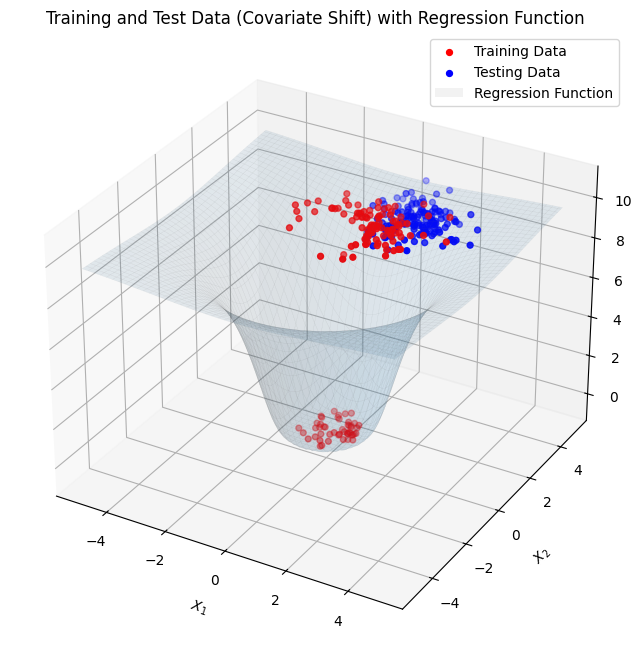

In [12]:
def plot_data_3d(
    cfg,
    n_tr: int = 80,
    n_te: int = 80,
    *,
    k: int = 2,
    grid_limits: Tuple[float, float] = (-5.0, 5.0),
    grid_size: int = 100,
    train_color: str = "red",
    test_color: str = "blue",
    surface_alpha: float = 0.1,
    ax: Optional["Axes3D"] = None,
    random_state: Optional[int] = None,
    title: str = "Training and Test Data (Covariate Shift) with Regression Function ",
    show: bool = True,
) -> Tuple[plt.Figure, "Axes3D"]:
    """Plot train/test points and the regression surface in 3D.

    Args:
        cfg: Config object exposing:
            - regression_function(X, k=...) -> vector of shape (n,)
            - sample_train/test functions (or call the provided ones below)
            - (Used here) means/covariances via those sampling helpers
        n_tr (int): Number of training samples to display.
        n_te (int): Number of testing samples to display.
        k (int): Shape parameter passed to `cfg.regression_function`.
        grid_limits (Tuple[float, float]): (min, max) range on both X-axes for surface grid.
        grid_size (int): Resolution of the surface grid per axis.
        train_color (str): Color for training points.
        test_color (str): Color for testing points.
        surface_alpha (float): Transparency for the surface.
        ax (Optional[Axes3D]): Existing 3D axes. If None, a new figure/axes is created.
        random_state (Optional[int]): RNG seed forwarded to sampling routines if supported.
        title (str): Plot title.
        show (bool): If True, calls plt.show() at the end.

    Returns:
        Tuple[plt.Figure, Axes3D]: The figure and 3D axes for further customization/saving.
    """
    # ---- Sample small subsets for a clear plot (uses your existing helpers) ----
    # If your helpers are named differently, adjust the two lines below accordingly.
    X_tr_plot, y_tr_plot = sample_train(cfg, n_tr=n_tr, random_state=random_state)
    X_te_plot, y_te_plot = sample_test(cfg, n_te=n_te, random_state=random_state)

    # ---- Build grid for rendering the regression surface ----
    lo, hi = grid_limits
    grid_lin = np.linspace(lo, hi, grid_size, dtype=np.float64)
    x_grid, y_grid = np.meshgrid(grid_lin, grid_lin)
    XY_grid = np.c_[x_grid.ravel(), y_grid.ravel()]  # (grid_size^2, 2)
    # Evaluate the regression function on the grid and reshape to surface
    z_grid = cfg.regression_function(XY_grid, k=k).reshape(x_grid.shape).astype(np.float64)

    # ---- Prepare axes ----
    created_ax = False
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        created_ax = True
    else:
        fig = ax.figure

    # ---- Scatter: training/testing ----
    # Use zorder to ensure points float above the surface
    ax.scatter(
        X_tr_plot[:, 0], X_tr_plot[:, 1], y_tr_plot,
        color=train_color, label="Training Data", zorder=3, s=18
    )
    ax.scatter(
        X_te_plot[:, 0], X_te_plot[:, 1], y_te_plot,
        color=test_color, label="Testing Data", zorder=3, s=18
    )

    # ---- Surface: regression function ----
    surf = ax.plot_surface(
        x_grid, y_grid, z_grid,
        alpha=surface_alpha,
        edgecolor="grey",
        linewidth=0.2,
        antialiased=True,
        zorder=1
    )

    # ---- Labels, grid, and legend ----
    ax.set_xlabel(r"$X_1$", labelpad=8)
    ax.set_ylabel(r"$X_2$", labelpad=8)
    ax.set_zlabel(r"$Y$",   labelpad=14)

    ax.set_title(title)

    # 3D gridlines are limited; still enable for reference
    ax.grid(True, linestyle="--", alpha=0.4)

    # Surface doesn't produce a legend handle automatically; create a proxy patch
    proxy_surface = Patch(facecolor="gray", alpha=surface_alpha, label="Regression ")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(proxy_surface)
    labels.append("Regression Function")
    ax.legend(handles, labels, loc="upper right")

    if show and created_ax:
        plt.show()

    return fig, ax

# plot figure
fig, ax = plot_data_3d(CFG, n_tr=150, n_te=150, k=1.5, grid_limits=(-5, 5), grid_size=100)
#fig.savefig("plotdata_3d.png", dpi=200)

## 5. Models introduction and related predictors

In [13]:
# classic KRR predictor
def KRR(K: np.ndarray, reg: float, y: np.ndarray)-> np.ndarray:
    n=K.shape[0]
    c=np.linalg.inv(K+n*reg*np.eye(n))@ y
    return c

# reweighted KRR predictor with IW Eq.(6)
def KRR_w(K: np.ndarray, reg: float, w:np.ndarray ,y: np.ndarray)-> np.ndarray:
    n=K.shape[0]
    M_w_inv = np.diag(1/w)
    assert(M_w_inv.shape[0]==n)
    c= np.linalg.inv(K+n*reg*M_w_inv)@y
    return c

# reweighted compressed KRR predictor with IW + Nyström Eq. (13)
def KRR_w_nyst(Knm: np.ndarray, Kmm: np.ndarray, reg: float, w: np.ndarray, y: np.ndarray)-> np.ndarray:
    m=Kmm.shape[0]
    n=Knm.shape[0]
    M_w = np.diag(w)
    c= np.linalg.pinv(Knm.T@M_w@Knm + n*reg*Kmm)@Knm.T@M_w@y
    return c

## 6. Cross-Validation

In [14]:
# cross validation hyperparameters lambda (regularization), gamma (lengthscale)
def cross_val(CFG,X: np.ndarray, Y: np.ndarray, model: str, n_splits: int =5)->Tuple[int,int]:
    kf = KFold(n_splits=n_splits, shuffle=True)

    best_mse = float('inf')

    for lambda_ in CFG.lambda_grid:
        for gamma in CFG.gamma_grid:
            fold_mse = []

            for tr_ind, val_ind in kf.split(X):
                X_tr, X_val = X[tr_ind], X[val_ind]
                Y_tr, Y_val = Y[tr_ind], Y[val_ind]

                if model=='KRR':
                    K = get_kernel_matrix(X_tr, X_tr, gamma)
                    c = KRR(K, lambda_, Y_tr)
                    Y_pr = c@get_kernel_matrix(X_tr,X_val,gamma)

                else:
                    w = weights(CFG, X_tr)                
                    if model=='KRR_w':
                        K = get_kernel_matrix(X_tr, X_tr, gamma)
                        c = KRR_w(K, lambda_, w, Y_tr)
                        Y_pr = c@get_kernel_matrix(X_tr,X_val,gamma)
                    
                    elif model=='KRR_w_nyst':
                        centers_dict = bless(X_tr, RBF(length_scale=1.), 3, 10, force_cpu=True,verbose=False)
                        X_nyst = centers_dict.X
                        K_nm = get_kernel_matrix(X_tr, X_nyst, gamma)
                        K_mm = get_kernel_matrix(X_nyst, X_nyst, gamma)
                        c = KRR_w_nyst(K_nm,K_mm,lambda_,w,Y_tr)
                        Y_pr = c@get_kernel_matrix(X_nyst,X_val,gamma)


                mse_val = mean_squared_error(Y_val, Y_pr)
                fold_mse.append(mse_val)

            avg_mse = np.mean(fold_mse)

            if avg_mse < best_mse:
                best_mse = avg_mse
                best_lambda = lambda_
                best_gamma = gamma

    return best_lambda, best_gamma

## 7. Models Training

In [15]:
# model training
def train(CFG, model: str, num_runs: int =5)-> Tuple[float, np.ndarray, ...]:
    mse_list = []

    for run in range(num_runs):
        X_tr, Y_tr = sample_train(CFG, random_state = run)
        X_te, Y_te = sample_test(CFG, random_state = run)

        best_lambda, best_gamma = cross_val(CFG, X_tr, Y_tr, model)

        if model=='KRR':
            K = get_kernel_matrix(X_tr, X_tr, best_gamma)
            c = KRR(K, best_lambda, Y_tr)
            Y_pr = c@get_kernel_matrix(X_tr,X_te,best_gamma)
        
        else:
            w = weights(CFG,X_tr)
            if model=='KRR_w':
                K = get_kernel_matrix(X_tr, X_tr, best_gamma)
                c = KRR_w(K, best_lambda, w, Y_tr)
                Y_pr = c@get_kernel_matrix(X_tr,X_te,best_gamma)
            
            elif model=='KRR_w_nyst':
                centers_dict = bless(X_tr, RBF(length_scale=1.), 3, 10, force_cpu=True,verbose=False)
                X_nyst = centers_dict.X
                K_nm = get_kernel_matrix(X_tr, X_nyst, best_gamma)
                K_mm = get_kernel_matrix(X_nyst, X_nyst, best_gamma)
                c = KRR_w_nyst(K_nm, K_mm, best_lambda, w, Y_tr)
                Y_pr = c @ get_kernel_matrix(X_nyst,X_te,best_gamma)

        

        mse = mean_squared_error(Y_te, Y_pr)

        mse_list.append(mse)

    return (mse_list, Y_pr, X_tr, Y_tr, X_te, Y_te)

## 8. Results & Summary

In [16]:

# This cell aggregates and prints results for all models in a clean table.

models = [
    ("KRR", "KRR"),
    ("IW-KRR", "KRR_w"),
    ("IW–Nyström KRR", "KRR_w_nyst"),
]

records = []
detailed = {}

for display_name, model_key in models:
    mse_list, Y_pr, X_tr, Y_tr, X_te, Y_te = train(CFG, model_key)
    mse_arr = np.asarray(mse_list, dtype=float)
    mu = float(np.mean(mse_arr))
    sd = float(np.std(mse_arr, ddof=1)) if len(mse_arr) > 1 else 0.0
    records.append(
        {
            "Model": display_name,
            "Mean MSE": mu,
            "Std MSE": sd,
            "Runs": len(mse_arr),
        }
    )
    detailed[model_key] = {
        "mse_list": mse_list,
        "Y_pred": Y_pr,
        "X_tr": X_tr,
        "Y_tr": Y_tr,
        "X_te": X_te,
        "Y_te": Y_te,
    }

df = pd.DataFrame.from_records(records).set_index("Model")

# Pretty print
pd.options.display.float_format = "{:,.4f}".format
print("=== Test Performance under Covariate Shift ===")
display(df.sort_values("Mean MSE"))

best = df["Mean MSE"].idxmin()
print(f"\nBest (by mean MSE): {best}  →  {df.loc[best, 'Mean MSE']:.4f} ± {df.loc[best, 'Std MSE']:.4f}")

# Optional: keep detailed outputs available in `detailed` for post-hoc analysis (plots, diagnostics).


=== Test Performance under Covariate Shift ===


,Mean MSE,Std MSE,Runs
Model,,,
IW-KRR,0.4085,0.1506,5
IW–Nyström KRR,0.4320,0.1609,5
KRR,0.9492,0.3952,5



Best (by mean MSE): IW-KRR  →  0.4085 ± 0.1506


## 8. Results & Summary (with Training Time)

In [17]:

# This cell aggregates and prints results for all models in a clean table, including total training time.

models = [
    ("KRR", "KRR"),
    ("IW-KRR", "KRR_w"),
    ("IW–Nyström KRR", "KRR_w_nyst"),
]

records = []
detailed = {}

for display_name, model_key in models:
    t0 = time.perf_counter()
    mse_list, Y_pr, X_tr, Y_tr, X_te, Y_te = train(CFG, model_key)
    t1 = time.perf_counter()
    elapsed = t1 - t0  # total time for cross-val + training across all runs for this model

    mse_arr = np.asarray(mse_list, dtype=float)
    mu = float(np.mean(mse_arr))
    sd = float(np.std(mse_arr, ddof=1)) if len(mse_arr) > 1 else 0.0
    records.append(
        {
            "Model": display_name,
            "Mean MSE": mu,
            "Std MSE": sd,
            "Runs": len(mse_arr),
            "Train Time (s)": elapsed,
        }
    )
    detailed[model_key] = {
        "mse_list": mse_list,
        "Y_pred": Y_pr,
        "X_tr": X_tr,
        "Y_tr": Y_tr,
        "X_te": X_te,
        "Y_te": Y_te,
        "train_time_seconds": elapsed,
    }

df = pd.DataFrame.from_records(records).set_index("Model")

# Pretty print
pd.options.display.float_format = "{:,.4f}".format
print("=== Test Performance under Covariate Shift (with Training Time) ===")
display(df.sort_values(["Mean MSE", "Train Time (s)"]))

best = df["Mean MSE"].idxmin()
print(f"\nBest (by mean MSE): {best}  →  {df.loc[best, 'Mean MSE']:.4f} ± {df.loc[best, 'Std MSE']:.4f}")
fastest = df["Train Time (s)"].idxmin()
print(f"Fastest to train:     {fastest}  →  {df.loc[fastest, 'Train Time (s)']:.3f} s")

# Optional: `detailed` keeps per-model artifacts and timing for post-hoc analysis.


=== Test Performance under Covariate Shift (with Training Time) ===


,Mean MSE,Std MSE,Runs,Train Time (s)
Model,,,,
IW-KRR,0.4085,0.1506,5,77.1754
IW–Nyström KRR,0.4168,0.1595,5,39.9027
KRR,0.9492,0.3952,5,71.4304



Best (by mean MSE): IW-KRR  →  0.4085 ± 0.1506
Fastest to train:     IW–Nyström KRR  →  39.903 s
